In [181]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Conv1D, MaxPooling1D
from sklearn.metrics import mean_squared_error

Mounted at /content/gdrive


# **Step 1 : Load the Data**

In [146]:
# Load the data
data = pd.read_csv('/content/gdrive/MyDrive/healthcare_dataset.csv')
data

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55495,eLIZABeTH jaCkSOn,42,Female,O+,Asthma,2020-08-16,Joshua Jarvis,Jones-Thompson,Blue Cross,2650.714952,417,Elective,2020-09-15,Penicillin,Abnormal
55496,KYle pEREz,61,Female,AB-,Obesity,2020-01-23,Taylor Sullivan,Tucker-Moyer,Cigna,31457.797307,316,Elective,2020-02-01,Aspirin,Normal
55497,HEATher WaNG,38,Female,B+,Hypertension,2020-07-13,Joe Jacobs DVM,"and Mahoney Johnson Vasquez,",UnitedHealthcare,27620.764717,347,Urgent,2020-08-10,Ibuprofen,Abnormal
55498,JENniFER JOneS,43,Male,O-,Arthritis,2019-05-25,Kimberly Curry,"Jackson Todd and Castro,",Medicare,32451.092358,321,Elective,2019-05-31,Ibuprofen,Abnormal


In [147]:
data.columns

Index(['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results'],
      dtype='object')

In [148]:
# Print the only columns i need
data=data[['Date of Admission']]
data

,Date of Admission
0,2024-01-31
1,2019-08-20
2,2022-09-22
3,2020-11-18
4,2022-09-19
...,...
55495,2020-08-16
55496,2020-01-23
55497,2020-07-13
55498,2019-05-25


# **Step 2 : Data Preprocessing**

In [149]:
# Parse 'Date of Admission' column and set it as index
data['Date of Admission'] = pd.to_datetime(data['Date of Admission'])

<ipython-input-149-93bcf4fbc54d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date of Admission'] = pd.to_datetime(data['Date of Admission'])


In [150]:
# Filtering data from zeros
data.filter(like='0.00',axis=None)
data

,Date of Admission
0,2024-01-31
1,2019-08-20
2,2022-09-22
3,2020-11-18
4,2022-09-19
...,...
55495,2020-08-16
55496,2020-01-23
55497,2020-07-13
55498,2019-05-25


In [151]:
data.describe()

,Date of Admission
count,55500
mean,2021-11-01 01:02:22.443243008
min,2019-05-08 00:00:00
25%,2020-07-28 00:00:00
50%,2021-11-01 00:00:00
75%,2023-02-03 00:00:00
max,2024-05-07 00:00:00


In [152]:
# Aggregate number of admissions per day
daily_admissions = data.groupby('Date of Admission').size().reset_index(name='admissions')

In [153]:
# Feature engineering: Extract day of the week, month, and year
daily_admissions['day_of_week'] = daily_admissions['Date of Admission'].dt.dayofweek
daily_admissions['month'] = daily_admissions['Date of Admission'].dt.month
daily_admissions['year'] = daily_admissions['Date of Admission'].dt.year

In [154]:
# Selecting relevant features
features = ['day_of_week', 'month', 'year', 'admissions']

In [155]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_admissions[features])

In [156]:
# Convert back to DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=features, index=daily_admissions['Date of Admission'])
scaled_data

,day_of_week,month,year,admissions
Date of Admission,,,,
2019-05-08,0.333333,0.363636,0.0,0.394737
2019-05-09,0.500000,0.363636,0.0,0.684211
2019-05-10,0.666667,0.363636,0.0,0.131579
2019-05-11,0.833333,0.363636,0.0,0.342105
2019-05-12,1.000000,0.363636,0.0,0.631579
...,...,...,...,...
2024-05-03,0.666667,0.363636,1.0,0.500000
2024-05-04,0.833333,0.363636,1.0,0.315789
2024-05-05,1.000000,0.363636,1.0,0.368421


# **Step 3 : Model Training**

In [157]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][-1])
    return np.array(X), np.array(y)

In [158]:
# Parameters
seq_length = 60  # Number of days to look back

# Create sequences
X, y = create_sequences(scaled_data.values, seq_length)

In [159]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [167]:
# Model definition
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

In [168]:
# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
36/36 [==============================] - 8s 88ms/step - loss: 0.0361 - val_loss: 0.0259
Epoch 2/30
36/36 [==============================] - 3s 71ms/step - loss: 0.0266 - val_loss: 0.0247
Epoch 3/30
36/36 [==============================] - 3s 82ms/step - loss: 0.0267 - val_loss: 0.0248
Epoch 4/30
36/36 [==============================] - 4s 100ms/step - loss: 0.0266 - val_loss: 0.0235
Epoch 5/30
36/36 [==============================] - 2s 65ms/step - loss: 0.0268 - val_loss: 0.0257
Epoch 6/30
36/36 [==============================] - 2s 60ms/step - loss: 0.0265 - val_loss: 0.0234
Epoch 7/30
36/36 [==============================] - 2s 60ms/step - loss: 0.0267 - val_loss: 0.0234
Epoch 8/30
36/36 [==============================] - 3s 83ms/step - loss: 0.0265 - val_loss: 0.0242
Epoch 9/30
36/36 [==============================] - 5s 152ms/step - loss: 0.0265 - val_loss: 0.0233
Epoch 10/30
36/36 [==============================] - 4s 123ms/step - loss: 0.0265 - val_loss: 0.0243
Epoch 

In [169]:
# Define and train MLP model
mlp_model = Sequential([
    Flatten(input_shape=(seq_length, X_train.shape[2])),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

In [170]:
mlp_model.compile(optimizer='adam', loss='mean_squared_error')
mlp_history = mlp_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)


Epoch 1/30
36/36 [==============================] - 1s 8ms/step - loss: 0.0499 - val_loss: 0.0249
Epoch 2/30
36/36 [==============================] - 0s 4ms/step - loss: 0.0308 - val_loss: 0.0268
Epoch 3/30
36/36 [==============================] - 0s 4ms/step - loss: 0.0274 - val_loss: 0.0241
Epoch 4/30
36/36 [==============================] - 0s 4ms/step - loss: 0.0280 - val_loss: 0.0245
Epoch 5/30
36/36 [==============================] - 0s 4ms/step - loss: 0.0260 - val_loss: 0.0245
Epoch 6/30
36/36 [==============================] - 0s 4ms/step - loss: 0.0275 - val_loss: 0.0252
Epoch 7/30
36/36 [==============================] - 0s 4ms/step - loss: 0.0264 - val_loss: 0.0238
Epoch 8/30
36/36 [==============================] - 0s 4ms/step - loss: 0.0254 - val_loss: 0.0250
Epoch 9/30
36/36 [==============================] - 0s 4ms/step - loss: 0.0269 - val_loss: 0.0273
Epoch 10/30
36/36 [==============================] - 0s 4ms/step - loss: 0.0250 - val_loss: 0.0244
Epoch 11/30
36/36 [

In [182]:
# Define and train CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

In [184]:
cnn_model.compile(optimizer='adam', loss='mean_squared_error')
cnn_history = cnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
36/36 [==============================] - 1s 10ms/step - loss: 0.0158 - val_loss: 0.0310
Epoch 2/30
36/36 [==============================] - 0s 6ms/step - loss: 0.0160 - val_loss: 0.0282
Epoch 3/30
36/36 [==============================] - 0s 7ms/step - loss: 0.0141 - val_loss: 0.0278
Epoch 4/30
36/36 [==============================] - 0s 7ms/step - loss: 0.0140 - val_loss: 0.0287
Epoch 5/30
36/36 [==============================] - 0s 7ms/step - loss: 0.0132 - val_loss: 0.0306
Epoch 6/30
36/36 [==============================] - 0s 7ms/step - loss: 0.0128 - val_loss: 0.0284
Epoch 7/30
36/36 [==============================] - 0s 8ms/step - loss: 0.0122 - val_loss: 0.0283
Epoch 8/30
36/36 [==============================] - 0s 7ms/step - loss: 0.0126 - val_loss: 0.0309
Epoch 9/30
36/36 [==============================] - 0s 7ms/step - loss: 0.0125 - val_loss: 0.0302
Epoch 10/30
36/36 [==============================] - 0s 7ms/step - loss: 0.0121 - val_loss: 0.0291
Epoch 11/30
36/36 

# **Step 4 : Model Evaluation**

In [171]:
# Evaluate lstm model
loss = lstm_model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {loss}')

# Calculate RMSE
y_pred = lstm_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse}')

12/12 [==============================] - 0s 18ms/step - loss: 0.0246
Test Loss (MSE): 0.02458832412958145
12/12 [==============================] - 1s 17ms/step
Test RMSE: 0.15680664477927433


In [172]:
# Evaluate MLP model
mlp_loss = mlp_model.evaluate(X_test, y_test)
print(f'MLP Test Loss (MSE): {mlp_loss}')
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_model.predict(X_test)))
print(f'MLP Test RMSE: {mlp_rmse}')

12/12 [==============================] - 0s 2ms/step - loss: 0.0284
MLP Test Loss (MSE): 0.02836906909942627
12/12 [==============================] - 0s 2ms/step
MLP Test RMSE: 0.16843119369997162


In [185]:
# Evaluate CNN model
cnn_loss = cnn_model.evaluate(X_test, y_test)
print(f'CNN Test Loss (MSE): {cnn_loss}')
cnn_rmse = np.sqrt(mean_squared_error(y_test, cnn_model.predict(X_test)))
print(f'CNN Test RMSE: {cnn_rmse}')

12/12 [==============================] - 0s 3ms/step - loss: 0.0416
CNN Test Loss (MSE): 0.04157691448926926
12/12 [==============================] - 0s 2ms/step
CNN Test RMSE: 0.20390416801267688


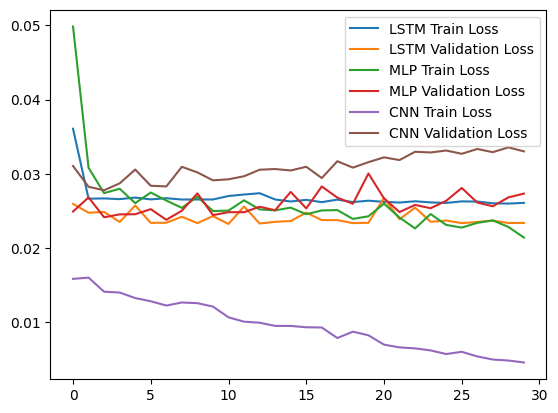

In [186]:
# Plot training history for all models
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.plot(mlp_history.history['loss'], label='MLP Train Loss')
plt.plot(mlp_history.history['val_loss'], label='MLP Validation Loss')
plt.plot(cnn_history.history['loss'], label='CNN Train Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.legend()
plt.show()

# **Step 5 : Forecasting**

In [174]:
# Forecasting future admissions
def forecast(model, data, seq_length, n_future):
    forecasted = []
    current_seq = data[-seq_length:].values

    for _ in range(n_future):
        current_seq = current_seq.reshape((1, seq_length, -1))
        prediction = model.predict(current_seq)
        forecasted.append(prediction[0, 0])

        # Shift the sequence and add the new prediction
        current_seq = np.roll(current_seq, -1, axis=1)
        current_seq[0, -1, -1] = prediction[0, 0]

    return forecasted

In [187]:
# Number of days to forecast
n_future = 60

# Forecast future admissions
future_admissions_lstm = forecast(lstm_model, scaled_data, seq_length, n_future)
future_admissions_mlp = forecast(mlp_model, scaled_data, seq_length, n_future)
future_admissions_cnn = forecast(cnn_model, scaled_data, seq_length, n_future)

# Inverse transform to original scale
future_admissions_lstm = scaler.inverse_transform([np.append(np.zeros(len(features)-1), x) for x in future_admissions_lstm])[:, -1]
future_admissions_mlp = scaler.inverse_transform([np.append(np.zeros(len(features)-1), x) for x in future_admissions_mlp])[:, -1]
future_admissions_cnn = scaler.inverse_transform([np.append(np.zeros(len(features)-1), x) for x in future_admissions_cnn])[:, -1]

1/1 [==============================] - 0s 23ms/step


In [188]:
# Create a DataFrame for future dates
future_dates = pd.date_range(start=daily_admissions['Date of Admission'].iloc[-1], periods=n_future+1)[1:]  # Skip the start date itself

forecast_df_lstm = pd.DataFrame({'date': future_dates, 'forecasted_admissions_lstm': future_admissions_lstm})
forecast_df_mlp = pd.DataFrame({'date': future_dates, 'forecasted_admissions_mlp': future_admissions_mlp})
forecast_df_cnn = pd.DataFrame({'date': future_dates, 'forecasted_admissions_cnn': future_admissions_cnn})

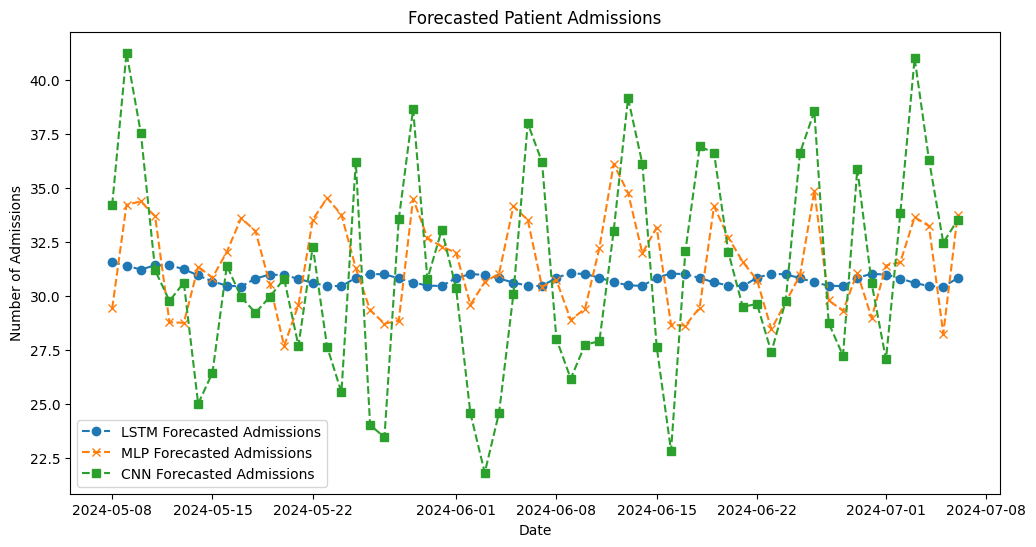

In [189]:
# Plot forecasted admissions
plt.figure(figsize=(12, 6))
plt.plot(forecast_df_lstm['date'], forecast_df_lstm['forecasted_admissions_lstm'], label='LSTM Forecasted Admissions', linestyle='--', marker='o')
plt.plot(forecast_df_mlp['date'], forecast_df_mlp['forecasted_admissions_mlp'], label='MLP Forecasted Admissions', linestyle='--', marker='x')
plt.plot(forecast_df_cnn['date'], forecast_df_cnn['forecasted_admissions_cnn'], label='CNN Forecasted Admissions', linestyle='--', marker='s')
plt.xlabel('Date')
plt.ylabel('Number of Admissions')
plt.title('Forecasted Patient Admissions')
plt.legend()
plt.show()